# Streaming in LangGraph

If we're building a responsive app for the users, real-time updates are key to keeping them engaged:

Common use-cases are:

1. Workflow progress (e.g. get state updates after each graph node is executed)

2. LLM tokens as they're generated.

3. Custom updates (e.g. "Fetched 10/100 records")


.stream and .astream are the sync and async methods for streaming back outputs from a graph run.

There are several different modes you can specify when calling these methods (e.g. 'graph.strem(input, stream_mode = "values")):

Most common modes are:

1. stream_mode = "values"
This streams the full value of the state after each step of the graph.

2. stream_mode = "updates"
This streams the updates to the state after each step of the graph 


In production apps, we usually want to stream more than the state.

In particular, with LLM calls it is common to stream the tokens as they generated.

we can do this using `.astream_events` method, which streams back events as they happen inside nodes

Each event ia a dict with a few keys:

`event` : This is the type of the event that is being emitted.

`name` : This is the name of the event.

`data` : This is the data associated with the event.

`metadata` : which contains  `langgraph_node` , the node emitting the event.



In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from typing import TypedDict, Annotated, Sequence, List, Literal
from langgraph.graph import add_messages, StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode

load_dotenv()

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools=tools)
# llm.bind_tools(...) wraps (Augments) an LLM with a set of “tools” so the model can emit structured tool calls (which your code can detect and execute) instead of only plain text. It returns a model-like object that, when invoked, may produce tool_calls describing which tool to run and with what arguments.


def model(state: AgentState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

def tools_router(state: AgentState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    

tool_node = ToolNode(tools=tools)

graph = StateGraph(AgentState)

graph.add_node("model", model)
graph.add_node("tool_node", tool_node)
graph.set_entry_point("model")

graph.add_conditional_edges("model", tools_router)
graph.add_edge("tool_node", "model")

app = graph.compile()

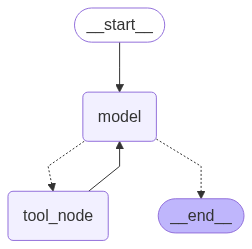

In [2]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [3]:

input = {
    "messages": ["What's the plot of the series Fubar on Netflix?"]
}

events = app.stream(input=input, stream_mode="values")

for event in events: 
    print(event["messages"])

[HumanMessage(content="What's the plot of the series Fubar on Netflix?", additional_kwargs={}, response_metadata={}, id='0e2160ca-d666-4711-8d88-04c892f75b0b')]
[HumanMessage(content="What's the plot of the series Fubar on Netflix?", additional_kwargs={}, response_metadata={}, id='0e2160ca-d666-4711-8d88-04c892f75b0b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tTCM2ZILW38exlKf0hyUcFEZ', 'function': {'arguments': '{"query":"Fubar Netflix series plot"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 90, 'total_tokens': 112, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_1827dd0c55', 'finish_reason': 'tool_calls', 'logprobs': None}, id='

In [4]:

input = {
    "messages": ["What's the plot of the series Fubar on Netflix?"]
}

events = app.stream(input=input, stream_mode="updates")

for event in events: 
    print(event)

{'model': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KciRVUqazvpwbJLfGqxSXssm', 'function': {'arguments': '{"query":"Fubar Netflix series plot"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 90, 'total_tokens': 112, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_1827dd0c55', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e0e16048-06e8-42a0-bd96-bf58f8d447a1-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Fubar Netflix series plot'}, 'id': 'call_KciRVUqazvpwbJLfGqxSXssm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 90, 'output_tokens': 22, 'total_tokens': 112})]}}
{'tool_no

In [5]:
input = {
    "messages": ["Hi, pls spit some facts aabout quantum entanglement"]
}

events = app.astream_events(input=input, version="v2")

async for event in events: 
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, pls spit some facts aabout quantum entanglement']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '69ebd5bf-1013-4299-9802-c69aba4a2e59', 'metadata': {}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, pls spit some facts aabout quantum entanglement']}}, 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'run_id': '765c511a-ea63-466f-be5f-f03c21cf392a', 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ('__start__',), 'langgraph_path': ('__pregel_pull', '__start__'), 'langgraph_checkpoint_ns': '__start__:67129740-b900-fe36-acdc-fcbb51f38359'}, 'parent_ids': ['69ebd5bf-1013-4299-9802-c69aba4a2e59']}
{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, pls spit some facts aabout quantum entanglement']}}, 'name': '_write', 'tags': ['seq:step:1', 'langsmith:hidden', 'langsmith:hidden'], 'run_id': '90d3a511-53c9-4870-857b-643614b9

In [6]:
input = {
    "messages": ["Hi, pls spit some facts aabout quantum entanglement"]
}

events = app.astream_events(input=input, version="v2")

async for event in events: 
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

Quantum entanglement is a fascinating and complex phenomenon in quantum physics. Here are some key facts about it:

1. **Definition**: Quantum entanglement occurs when particles become interconnected in such a way that the state of one particle is directly related to the state of another, no matter the distance between them.

2. **Non-locality**: One of the most intriguing aspects of entanglement is that it seems to violate classical intuitions about locality. Changes to one entangled particle instantly affect its partner, regardless of the distance separating them. This is sometimes referred to as "spooky action at a distance," a term coined by Albert Einstein.

3. **EPR Paradox**: In 1935, Einstein, Podolsky, and Rosen published a paper challenging the completeness of quantum mechanics, known as the EPR paradox. They used entanglement to argue that quantum mechanics could not be a complete theory of reality.

4. **Bell's Theorem**: In the 1960s, physicist John Bell developed Bell's T